In [8]:
import numpy as np
import pandas as pd
import os
from cdt.causality.graph import SAM
import networkx as nx


import matplotlib.pyplot as plt
import seaborn as sns
from reducer import*
from super_learner import*
from TLP import TLP
from scipy.stats import t


from auto_IF import *

from bd_SMDAG import *


## 0. Causal Pipeline for Psychologists and Social Scientists

This notebook accompanies a paper presenting a causal research pipeline for psychologists and social scientists. The purpose of the notebook is not to detail every possible in a typical research project, but to demonstrate the key steps necessary along the way. It is important to remember, for instance, that deriving a theory about which we are confident can take some back-and-forth, and the output of the causal discovery algorithm is very unlikely to be sufficient on its own. Therefore, in practice, apply the steps in this notebook with caution and dilligence. 

### 1. Data Preparation

Here we import and tidy up the data. We also normalize it (regardless of whether the variables are discrete or continuous) because some causal discovery algorithms incorportating score based objectives have been shown to be highly sensitive to variance (Reisach et al. 2021: https://arxiv.org/abs/2102.13647)


In [3]:
fn = 'wide_format_cat_encoded_EPFL.csv'

df = pd.read_csv(fn)
df = df.drop(['RID', 'SID', 'CID', 'RGEND', 'SGEND', 'GENRELNS'], axis=1) # remove uncoded variables
cols = df.columns
print(cols)
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

rename_cols = ['Cohab_Len', 'Age_R', 'Advrs_R', 'Distress_R', 'Support_R', 'Rel_Sat_R', 'R_DCI_S', 'R_DCI_R', 'DCI_Dyd_R', 
               'Dep_R', 'Age_S', 'Advrs_S', 'Distress_S', 'Support_S', 'Rel_Sat_S', 'S_DCI_S', 'S_DCI_R', 'DCI_Dyd_S',
                'Dep_S', 'Rel_Type', 'Gender_R', 'Gender_S']
df.columns = rename_cols


# reorder columns
col_order = ['Age_R', 'Age_S', 'Gender_R', 'Gender_S', 'Rel_Type', 'Advrs_R', 'Advrs_S', 'Distress_R', 'Support_R',
            'Distress_S', 'Support_S', 'R_DCI_S', 'R_DCI_R', 'DCI_Dyd_R', 'S_DCI_S', 'S_DCI_R', 'DCI_Dyd_S', 'Cohab_Len', 
            'Rel_Sat_R', 'Rel_Sat_S', 'Dep_R', 'Dep_S']
df = df[col_order]

cols = df.columns

print(cols, len(cols), len(col_order),)

# standardize the data for causal discovery
df_cd = (df-df.mean()) / df.std()
cols

Index(['YRSLIV', 'RAGE', 'RTOTADVRS', 'Rdistress_intensity', 'Rsupport',
       'Rsatisfaction', 'RDCI_s_response_r', 'RDCI_r_response_s',
       'RDCI_dyadic', 'RDEPSYM', 'SAGE', 'STOTADVRS', 'Sdistress_intensity',
       'Ssupport', 'Ssatisfaction', 'SDCI_s_response_r', 'SDCI_r_response_s',
       'SDCI_dyadic', 'SDEPSYM', 'GENRELNS_coded', 'RGEND_coded',
       'SGEND_coded'],
      dtype='object')
(419, 22)
(403, 22)
Index(['Age_R', 'Age_S', 'Gender_R', 'Gender_S', 'Rel_Type', 'Advrs_R',
       'Advrs_S', 'Distress_R', 'Support_R', 'Distress_S', 'Support_S',
       'R_DCI_S', 'R_DCI_R', 'DCI_Dyd_R', 'S_DCI_S', 'S_DCI_R', 'DCI_Dyd_S',
       'Cohab_Len', 'Rel_Sat_R', 'Rel_Sat_S', 'Dep_R', 'Dep_S'],
      dtype='object') 22 22


Index(['Age_R', 'Age_S', 'Gender_R', 'Gender_S', 'Rel_Type', 'Advrs_R',
       'Advrs_S', 'Distress_R', 'Support_R', 'Distress_S', 'Support_S',
       'R_DCI_S', 'R_DCI_R', 'DCI_Dyd_R', 'S_DCI_S', 'S_DCI_R', 'DCI_Dyd_S',
       'Cohab_Len', 'Rel_Sat_R', 'Rel_Sat_S', 'Dep_R', 'Dep_S'],
      dtype='object')

### 2. Create a skeleton which constrains the causal discovery

Here we use our initial theory to constrain the possible causal structure (e.g. no links backwards in time).

In [4]:
# nothing can cause:
no_causes = [0,1,2,3,4,5,6]

# constrain causal links
skeleton = 1- np.eye((len(cols)),dtype=np.float32)
skeleton[:, no_causes] = 0

# specify more specific causal link (or rather, the absence thereof)
group_cause_A = np.array([11,12,13,14,15,16,17])  
group_effect_A = np.array([7,8,9,10])  # group cause A cannot affect group effect A

group_cause_B = np.array([18, 19, 20, 21])
group_effect_B = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])  # group cause B cannot affect group effect B


for cause in group_cause_A:
    for effect in group_effect_A:
        skeleton[cause, effect] = 0
for cause in group_cause_B:
    for effect in group_effect_B:
        skeleton[cause, effect] = 0
        
print(skeleton, skeleton.shape) 

[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

### 3. Run causal disc.

Here we use SAM (Kalainathan et al. 2020). We take the result averaged over 50 initializations.

In [4]:
'''lr (float) – Learning rate of the generators
dlr (float) – Learning rate of the discriminator
mixed_data (bool) – Experimental – Enable for mixed-type datasets
lambda1 (float) – L0 penalization coefficient on the causal filters
lambda2 (float) – L2 penalization coefficient on the weights of the neural network
nh (int) – Number of hidden units in the generators’ hidden layers (regularized with lambda2)
dnh (int) – Number of hidden units in the discriminator’s hidden layers
train_epochs (int) – Number of training epochs
test_epochs (int) – Number of test epochs (saving and averaging the causal filters)
batch_size (int) – Size of the batches to be fed to the SAM model Defaults to full-batch
losstype (str) – type of the loss to be used (either ‘fgan’ (default), ‘gan’ or ‘mse’)
dagloss (bool) – Activate the DAG with No-TEARS constraint
dagstart (float) – Controls when the DAG constraint is to be introduced in the training (float ranging from 0 to 1, 0 denotes the start of the training and 1 the end)
dagpenalisation (float) – Initial value of the DAG constraint
dagpenalisation_increase (float) – Increase incrementally at each epoch the coefficient of the constraint
functional_complexity (str) – Type of functional complexity penalization (choose between ‘l2_norm’ and ‘n_hidden_units’)
hlayers (int) – Defines the number of hidden layers in the generators
dhlayers (int) – Defines the number of hidden layers in the discriminator
sampling_type (str) – Type of sampling used in the structural gates of the model (choose between ‘sigmoid’, ‘sigmoid_proba’ and ‘gumble_proba’)
linear (bool) – If true, all generators are set to be linear generators
nruns (int) – Number of runs to be made for causal estimation Recommended: >=32 for optimal performance
njobs (int) – Numbers of jobs to be run in Parallel Recommended: 1 if no GPU available, 2*number of GPUs else
gpus (int) – Number of available GPUs for the algorithm
verbose (bool) – verbose mode
'''

lrs = [0.01]
daglosses = [True]
dagpenalizations = [0.05]
num_runs = 2



'''skeleton (numpy.ndarray) – 
A priori knowledge about the causal relationships as an adjacency matrix. 
Can be fed either directed or undirected links.
'''


for lr in lrs:
    for dagloss in daglosses:
        for dagpenalization in dagpenalizations:
            print(dagpenalization)
            
            settings = 'lr_' + str(lr) + '_dagloss_' + str(dagloss) + '_dagpen_' + str(dagpenalization) + '_numruns_' + str(num_runs)
            
            obj = SAM(lr=lr, dlr=0.001, mixed_data=True, lambda1=10, lambda2=0.001, nh=20,
                       dnh=200, train_epochs=3000, test_epochs=800, batch_size=- 1, losstype='fgan',
                       dagloss=dagloss, dagstart=0.5, dagpenalization=0, dagpenalization_increase=dagpenalization, 
                        hlayers=2, dhlayers=2, sampling_type='sigmoidproba',
                       linear=False, nruns=num_runs, njobs=1, gpus=1, verbose=None)

            output = obj.predict(df_cd, graph=skeleton.T) 
            
            nx.write_gml(output, "graphs/SAM_solution_{}.gml".format(settings))

            
       
    

0.05


  0%|          | 9/3800 [00:01<45:26,  1.39it/s, disc=0.362, gen=-.0247, regul_loss=5.98, tot=-2.9]  Process Process-2:
Process Process-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/CausalDiscoveryToolbox/cdt/utils/parallel.py", line 53, in worker_subprocess
    sleep(1)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/CausalDiscoveryToolbox/cdt/utils/parallel.py", line 54, in worker_subprocess
    output = function(*args, **kwargs, device=device, idx=idx)
  File "/CausalDiscoveryToolbox/cdt/causality/graph/SAM.py", line 275, in r

KeyboardInterrupt: 

### 4. Threshold the discovered structure.

SAM gives us an adjacency matrix with continuous 'confidences' between 0 and 1. Thus, we need to decide on a threshold. Looking at the distribution of confidences can give us some idea of where to threshold. We go for 0.5.

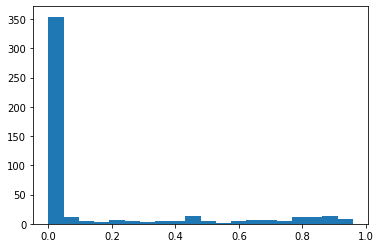

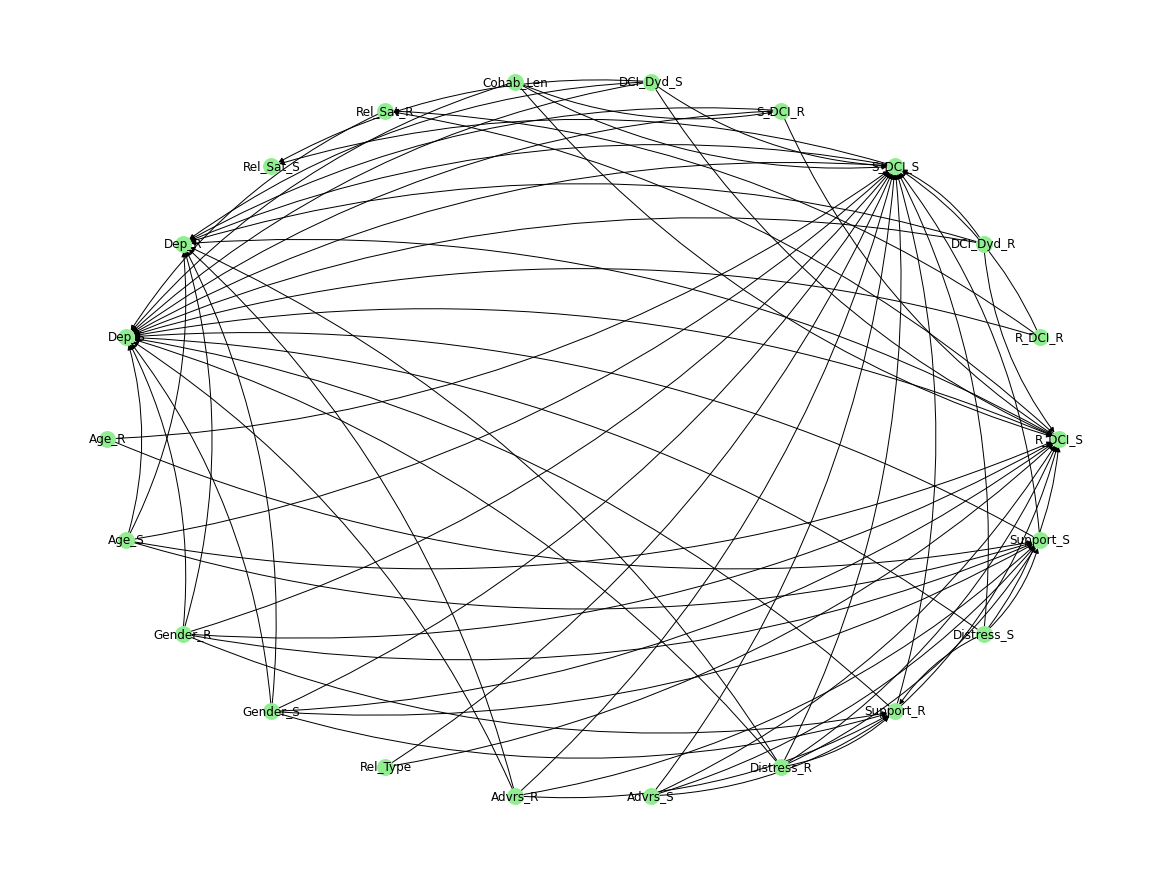

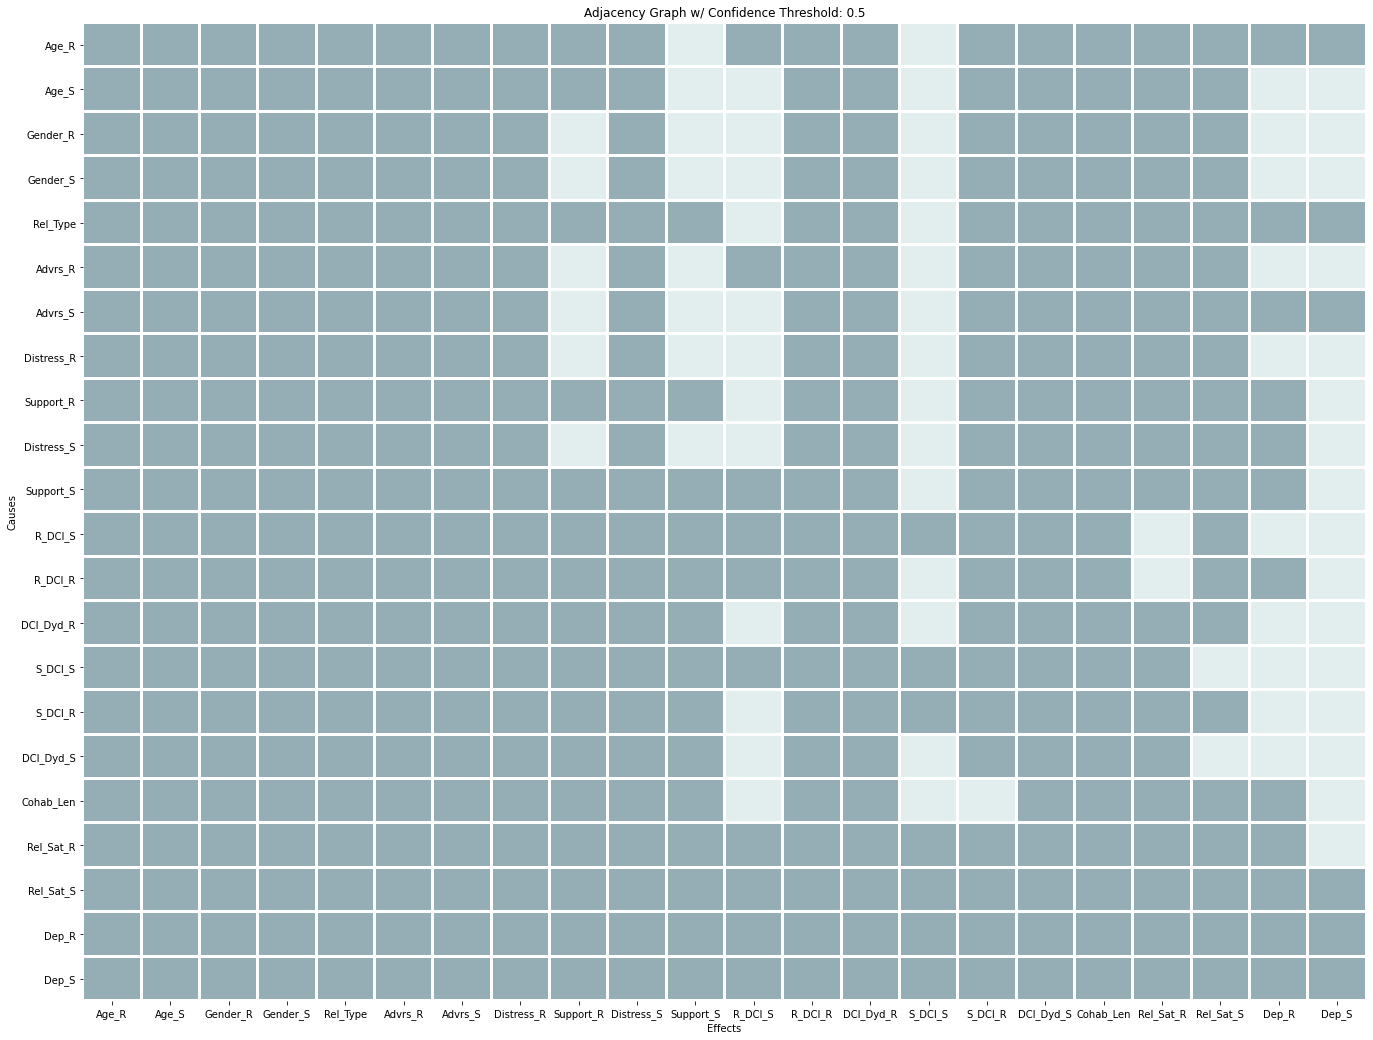

In [5]:
def threshold_graph(digraph, threshold):
    cols = digraph.nodes
    # to dense
    cm = nx.adjacency_matrix(digraph).todense()

    plt.hist(cm.ravel().T, bins=20)
    plt.show()

    # threshold
    cm[cm < threshold] = 0.0
    cm[cm >= threshold] = 1.0
    
    # back to graph 
    df_cm = pd.DataFrame(cm, index =cols,
                  columns = cols)
    digraph = nx.from_pandas_adjacency(df_cm.T, create_using=nx.DiGraph())
    
    return digraph

def get_rents_children(graph, var):
    rents = list(graph.predecessors(var))
    children = list(graph.successors(var))
    return rents, children


    
def plot_subbgraph(G, variables, size=(10,8), subgraph_name='name', plot_adj=False):
    H = nx.subgraph(G, variables)
    variables = H.nodes
        
    cmap=plt.get_cmap('cool')
#     pos = nx.spring_layout(H)
    edge_widths = [w for (*edge, w) in H.edges.data('weight')]
    edge_colors = [w for (*edge, w) in H.edges.data('weight')]
    vmin = min(edge_colors)
    vmax = max(edge_colors)
    


    plt.figure(figsize=size)
    nx.draw_shell(H, width=edge_widths, with_labels=True, vmin=vmin, vmax=vmax,
            node_color='lightgreen', edge_color='k', 
            node_size=250, connectionstyle='arc3, rad=.15')   
    plt.savefig('results/' + subgraph_name + '.png', dpi=150)
    plt.show()
    
 
    
    if plot_adj:
        cmap = plt.get_cmap('bone')
        cm = nx.adjacency_matrix(H).todense()
        df_cm = pd.DataFrame(cm, index=variables,
                  columns=variables)

        plt.figure(figsize = (23,18))
        sns.heatmap(df_cm.clip(lower=0.4, upper=0.7),cbar=False, linewidths=2, vmin=0.3, vmax=0.8, cmap=cmap, center=0.2)
        plt.xlabel('Effects')
        plt.ylabel('Causes')
        name = 'Adjacency Graph w/ Confidence Threshold: {}'.format(threshold)
        plt.savefig('results/' + subgraph_name + '_adj.png', dpi=150)
        plt.title(name)
        plt.show()  
        



    

title ='S'
graph_name = 'SAM_solution_lr_0.01_dagloss_True_dagpen_0.05_numruns_2.gml'
graph_name_short = '.'.join(graph_name.split('.')[:-1])

output = nx.read_gml("graphs/" + graph_name, destringizer=int)

threshold = 0.5
G_thresh = threshold_graph(output, threshold=threshold)
plot_subbgraph(G=G_thresh, variables=cols, subgraph_name=title+graph_name_short + '_all_{}'.format(threshold), size=(16,12), plot_adj=True)

### 5. Remove any cycles in the graph.

We plan to use the DAG framework to identify and estimate the causal effect of interest. We therefore need the graph to be acylclic. In practice, some time may be required to remove these links or integrate them into the theory and use a different analytical method. For the purposes of demonstration, we just remove the links as they appear.

In [6]:
glen = 1
while glen > 0:
    cycle_list = list(nx.simple_cycles(G_thresh))
    print(cycle_list)
    glen = len(cycle_list)
    if glen == 0:
        break
    else:
        G_thresh.remove_edge(cycle_list[0][0], cycle_list[0][1])
        

[]


... As it turns out, there were no cycles anyway.



### 6. Add unobserved confounders with edge plausibility scores
Causal discovery algorithms are not good at inferring unobserved confounders with observational data. Therefore, to improve the plausibility of our discovered graph, we should be conservative and incorporate some unobserved confounders.

In particular, we include some confounders between dyadic variables (like relationships satisfaction for each partner).

In [11]:
# assign weights of 1 to 'observed' edges
for u,v,d in G_thresh.edges(data=True):
    d['weight'] = 1.0

# introduced confounders and probabilities betwen 0.5 and 1 
# (probs < 0.5 are less than likely to exist, so are omitted)
G_thresh.add_edge('U1','Dep_S', weight=0.6)
G_thresh.add_edge('U1','Dep_R', weight=0.6)
G_thresh.add_edge('U2','Rel_Sat_S', weight=0.7)
G_thresh.add_edge('U2','Rel_Sat_R', weight=0.7)
G_thresh.add_edge('U3','Support_R', weight=0.6)
G_thresh.add_edge('U3','Support_S', weight=0.6)
G_thresh.add_edge('U4','Dep_R', weight=0.55)
G_thresh.add_edge('U4','Distress_R', weight=0.55)
G_thresh.add_edge('U4','Dep_S', weight=0.55)
G_thresh.add_edge('U4','Distress_S', weight=0.55)
G_thresh.add_edge('U5','S_DCI_S', weight=0.55)
G_thresh.add_edge('U5','S_DCI_R', weight=0.55)
G_thresh.add_edge('U6','DCI_Dyd_R', weight=0.55)
G_thresh.add_edge('U6','DCI_Dyd_S', weight=0.55)




### 7.  Reduce the graph 

The graph is evidently quite large, and yet we may only be interested in estimating a very specific effect. This is not a bad thing - we should have a large graph to ensure we get (for example) the variables necessary to at least form a Markov Blanket around the effect(s) we care about. Once we have our graph and our research question, however, there are likely opportunities to reduce the graph to the key variable for estimation (backdoor adjustment variables, the cause and outcomes of interest, and any precision variables).

The causal pipeline package has a number of ways to do this. But given that we have edge probabilities, we should start with the backdoor semi markovian reduction algorithms in bd_SMGDAG.

In [17]:
outcome = 'Dep_R'
cause = 'Distress_R'

# TEST BACKDOOR ID already
check, bd_set = check_bd_id(graph=G_thresh, X=cause, Y=outcome)

if check:
    print('Is identifiable with backdoor set:', bd_set)
else:
    print('Backdoor criterion not fulfilled, finding confounders to remove...')
    # RUNNING BRUTE FORCE ALGO TO FIND SOLUTION AND COST
    E, best_cost = bd_brute(graph=G_thresh, X=cause, Y=outcome)

    if best_cost != np.inf:
        print('Identifiable with the removal of:', E, ' at a cost of:', best_cost)
    else:
        print('No solution.')

    if best_cost != 0:
        # FINDING PLAUSIBILITY RATIO OF SOLUTION TO ORIGINAL GRAPH
        before_logsum, after_logsum, cutset_invlogsum = get_probs(E, G_thresh)
        ratio = np.exp((after_logsum + cutset_invlogsum)) / np.exp(before_logsum)
        print('Plausibility ratio:', ratio)
    else:
        ratio = 1.0

    # REMOVE NODES FROM GRAPH AND TEST BACKDOOR ID AGAIN, PROVIDING SUFFICIENT ADJUSTMENT SET
    for node in E:
        G_thresh.remove_node(node)

    check, bd_set = check_bd_id(graph=G_thresh, X=cause, Y=outcome)

    if check:
        print('Is identifiable with backdoor set:', bd_set)
    else:
        print('Backdoor criterion not fulfilled.')

Backdoor criterion not fulfilled, finding confounders to remove...
pruning
pruning
pruning
pruning
Identifiable with the removal of: {'U4'}  at a cost of: 0.55
Plausibility ratio: 0.8181818181818182
Is identifiable with backdoor set: []


The results above tell us that U4 was stopping us from achieving backdoor identification, and that after its removal, our graph is given a before-after plausibility ratio of 0.8. One can interpret this as - our new graph is 80% as plausible as the original graph, assuming the original was correct.

Number of edges before reduction:  72
Number of edges after reduction:  70


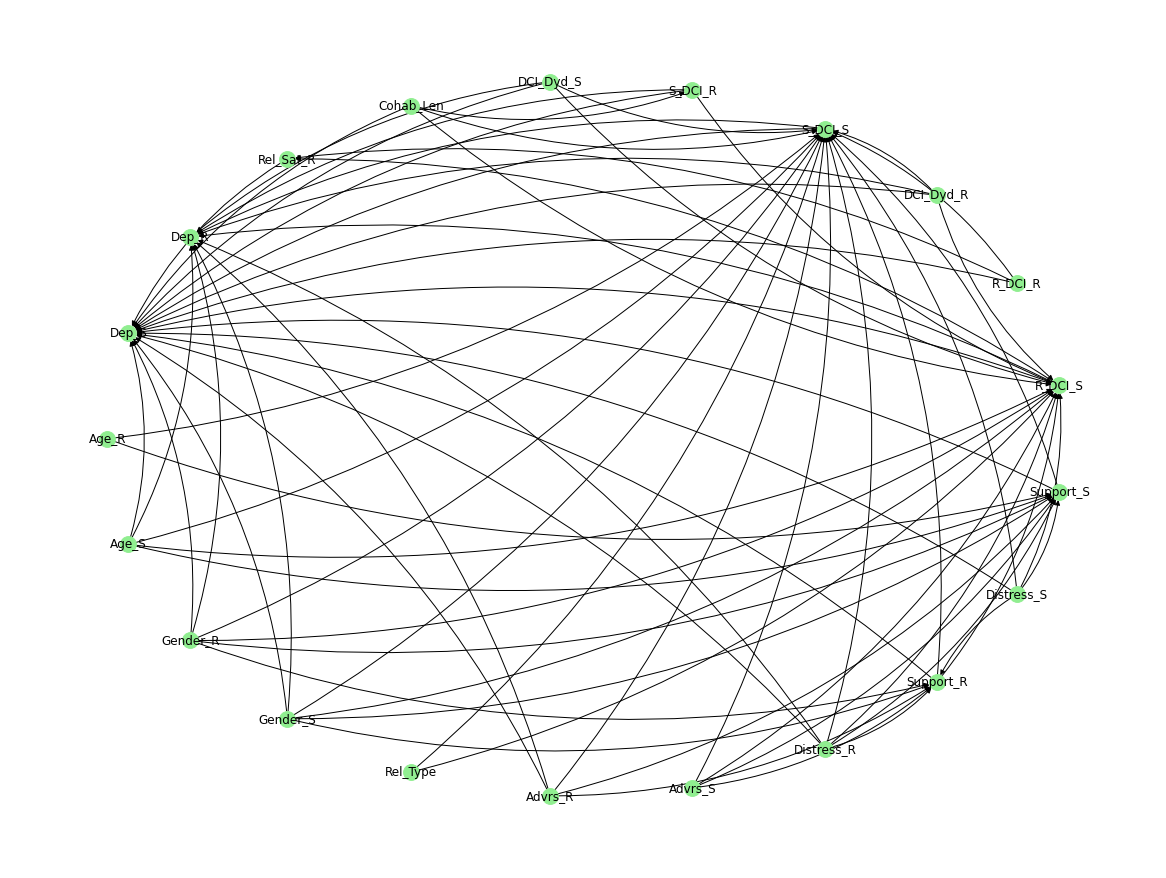

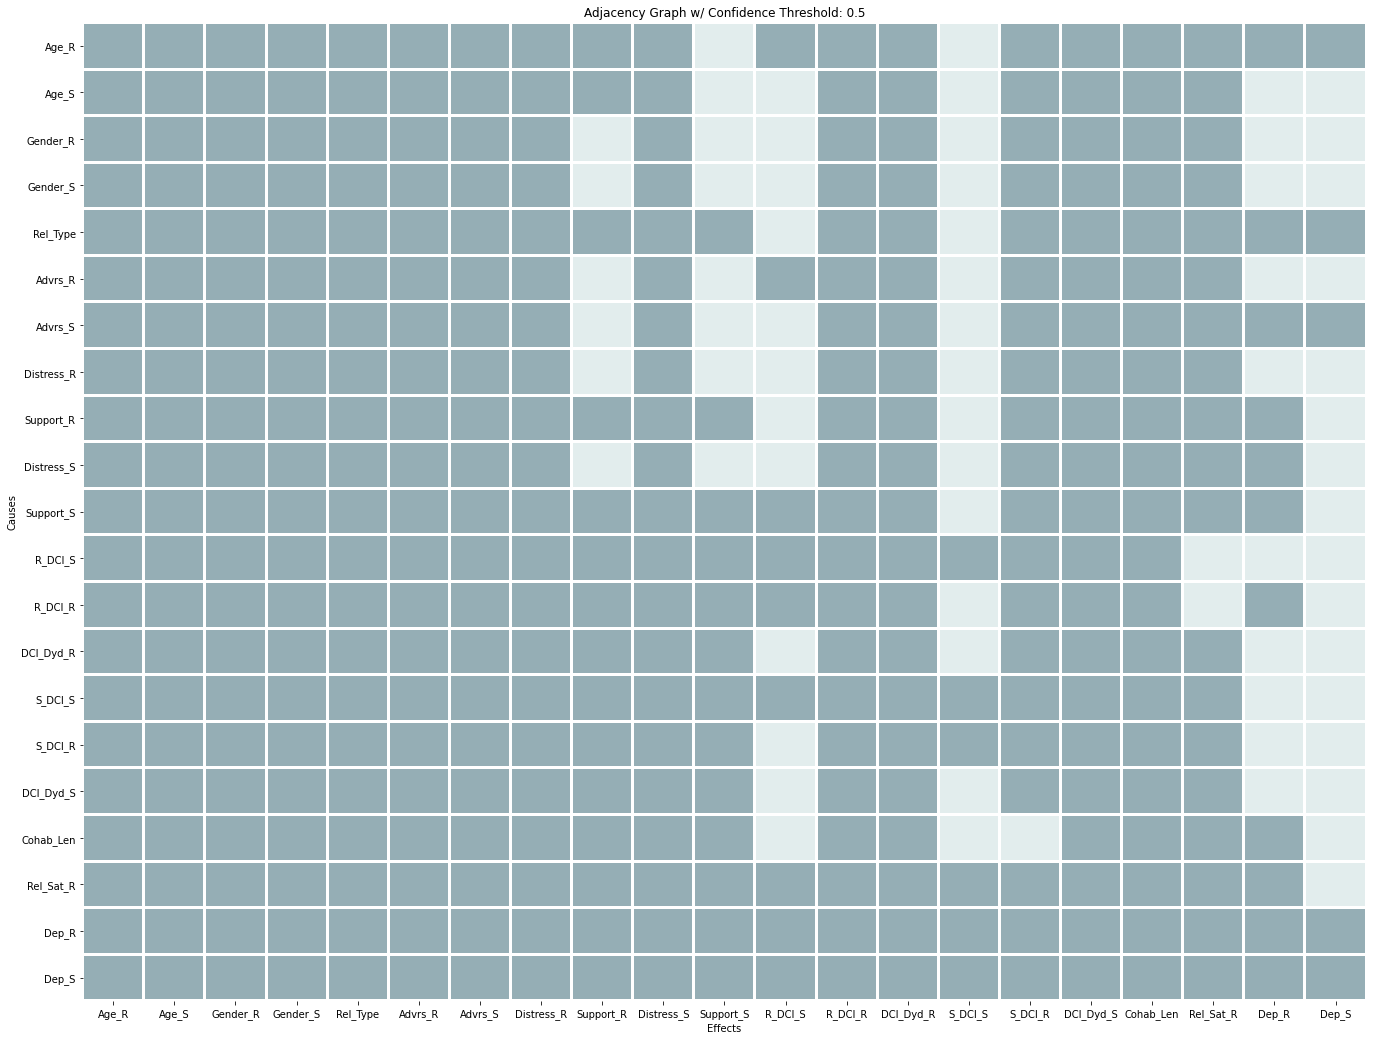

In [6]:
rd, confs, precs = reducer(G_thresh, [cause], [outcome],  remove_precision=False, project_causes=True, project_confs=True)

print('Number of edges before reduction: ', len(list(G_thresh.edges())))
print('Number of edges after reduction: ', len(list(rd.edges())))

# plot the reduced graph
plot_subbgraph(G=rd, variables=cols, subgraph_name=title+graph_name_short + '_reduced_{}'.format(threshold), size=(16,12), plot_adj=True)

### 7. Identify the Effect

For this we use the causaleffect package https://github.com/pedemonte96/causaleffect  https://arxiv.org/abs/2107.04632

N.B. The function only accepts graph variable/node names without spaces. e.g. 'Dep R' should be 'Dep_R'. verbose=False is recommended.

In [7]:
# not working yet!   
s = check_id(rd, cause=cause, effect=outcome, verbose=False)

### 8. Targeted Learning and Inference

1. Specify the outcome min and max - we will transform the outcome into the range 0 to 1, so need the max and mins of the scale! 
2. Specify the SuperLearner dictionaries for the treatment(G) and outcome (Q) models  See Phillips et al. (2022) for some recommendations https://arxiv.org/abs/2204.06139
3. Get the min and max from the scale ranges (the reason we have them in this format is so that this can easily be extend to be used with multiple outcomes one after another
4. Check list of confounders and precision variables. It so happens that there are no confounders for this choice of treatment and outcome. This is not a problem for tareted learning - we simply compute the marginal probabilities of belonging to a certain treatment group, and the G superlearner is not used.
5.  Specify whether the outcome is continuous of categorical (in our case it is continuous)
6. Make sure the treatment variable has the reference group as 0. For example, in our data, Distress_R ranges from 1 to 5, so if we want group 1 to be the reference, we subtract one from all datapoints.  Also specify the group comparisons required for the chosen treatment.
7. Set the number of folds in k-fold. See Phillips et al. (2022) for some recommendations https://arxiv.org/abs/2204.06139
8. Initialise a TLP targeted learning class and run targeted learning

In [60]:
# step 1
outcome_scale_ranges = [11, 37]


# step 2
est_dict_Q = ['Elastic', 'BR', 'SV', 'LR', 'RF', 'MLP', 'AB', 'poly']
est_dict_G = ['LR', 'NB', 'MLP','SV', 'poly', 'RF','AB']

# step 3
i = 0
outcome_min, outcome_max = outcome_scale_ranges[0], outcome_scale_ranges[1]

# step 4
print('outcome: ', outcome, '. cause: ', cause, '. Confounders:', confs, '. Precisions:', precs, '\n')

# step 5
outcome_type = 'reg'  # 'reg' or 'cls'

# step 6
df.Distress_R = df.Distress_R - 1  # don't do this multiple times!
group_comparisons =[[2,0], [4,0]]  # comparison in list format with 'group B [vs] reference_group'

# step 7
k = 8  # number of folds for SL training

# step 8
tlp = TLP(df, cause=cause, outcome=outcome, confs=list(confs),
          precs=list(precs), outcome_type=outcome_type, Q_learners=est_dict_Q, G_learners=est_dict_G,
         outcome_upper_bound=outcome_max, outcome_lower_bound=outcome_min)

# step 9 
 # fit SuperLearners
all_preds_Q, gts_Q, all_preds_G, gts_G = tlp.fit(k=k, standardized_outcome=False, calibration=True)

# 'do' targeted learning
pre_update_effects, post_update_effects, ses, ps = tlp.target_multigroup(group_comparisons=group_comparisons)


naive_effects = {}
naive_ses = {}
naive_ps = {}
for group_comparison in group_comparisons:
    group_a = group_comparison[0]
    group_ref = group_comparison[1]

    data_a = (df[df[cause] == group_a][outcome] - outcome_min) / (outcome_max - outcome_min)
    data_ref = (df[df[cause] == group_ref][outcome] - outcome_min) / (outcome_max - outcome_min)
    na = len(data_a)
    nref = len(df)
    naive = data_a.mean() - data_ref.mean()
    data_a_se = np.std(data_a, ddof=1) / (np.sqrt(na))
    data_ref_se = np.std(data_ref, ddof=1) / (np.sqrt(nref))
    diff_se = np.sqrt(data_a_se**2 + data_ref_se**2)

    upper, lower = naive + 1.96*diff_se, naive - 1.96*diff_se

    p = 2 * (1 - t.cdf(np.abs(naive) /diff_se, na+nref))

    naive_effects[str(group_comparison)] = naive
    naive_ses[str(group_comparison)] = (diff_se, upper, lower)
    naive_ps[str(group_comparison)] = p


 55%|█████▍    | 6/11 [00:00<00:00, 56.66it/s]

outcome:  Dep_R . cause:  Distress_R . Confounders: set() . Precisions: {'Distress_S', 'S_DCI_R', 'Age_R', 'Gender_S', 'Advrs_R', 'Rel_Type', 'Cohab_Len', 'R_DCI_R', 'Gender_R', 'Age_S', 'DCI_Dyd_S', 'DCI_Dyd_R', 'Advrs_S'} 

Training Q Learners...


100%|██████████| 11/11 [00:00<00:00, 18.01it/s]


Generating QAW Predictions 
Bounding outcome predictions.
No confounders, computing marginal probabilities of treatment.
Generating Predictions for Counterfactual Outcomes
Estimating Clever Covariates
Estimating Fluctuation Parameters
Updating Initial Counterfactual Predictions
Deriving the Influence Function, standard error, CI bounds and p-values


### 9. Plot the results / perform inference

We can see that the targeting step has increased the precision of the estimates compared with the naive group differences. In this example, there were no confounders for our choice of cause and effect. But one could set the list of confounders to be empty (if it isn't) and re-run it, to get an estimation for how much the confounders are affecting the estimate under deliberate structural misspecification. With this one can create a sensitivity analysis by comparing the results for different amounts of structural misspecificatoin.

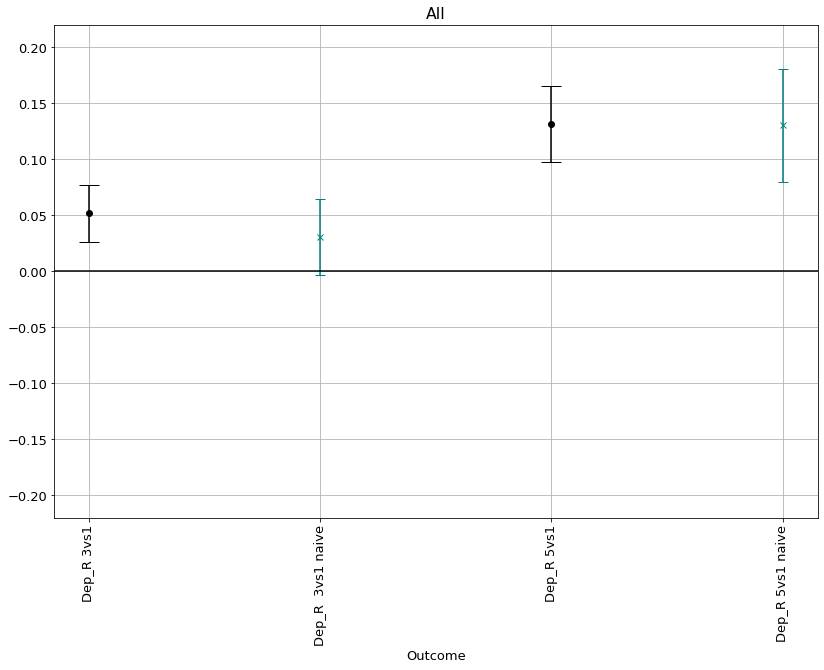

In [68]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(12,8))


est_2_0 = post_update_effects['[2, 0]']
err_2_0 = 1.96 * ses['[2, 0]'][0]

est_2_0_naive = naive_effects['[2, 0]']
err_2_0_naive = 1.96 * naive_ses['[2, 0]'][0]

est_4_0 = post_update_effects['[4, 0]']
err_4_0 = 1.96 * ses['[4, 0]'][0]

est_4_0_naive = naive_effects['[4, 0]']
err_4_0_naive = 1.96 * naive_ses['[4, 0]'][0]


plt.errorbar(x=[outcome + ' 3vs1'], y=est_2_0, yerr=err_2_0, capsize=10, fmt='o', color='k')
plt.errorbar(x=[outcome + '  3vs1 naive'], y=est_2_0_naive, yerr=err_2_0_naive, capsize=5, fmt='x', color='teal')

plt.errorbar(x=[outcome + ' 5vs1'], y=est_4_0, yerr=err_4_0, capsize=10, fmt='o', color='k')
plt.errorbar(x=[outcome + ' 5vs1 naive'], y=est_4_0_naive, yerr=err_4_0_naive, capsize=5, fmt='x', color='teal')


plt.title('All') 
plt.xlabel('Outcome')   
plt.axhline(y = 0, color = 'k', linestyle = '-') 
plt.grid()
plt.tight_layout()
plt.xticks(rotation = 90)
plt.ylim(-.22, .22)
plt.savefig('tl_results/' + outcome+'_targeted_comparison.png', bbox_inches="tight", dpi=200)

plt.show()

True C A ()
True C K ()
False C X ()
False C F ()
False C D ()
False C G ()
False C H ()
False C Y ()
False A K ()
False A X ()
False A F ()
False A D ()
False A G ()
False A H ()
False A Y ()
False K X ()
False K F ()
False K D ()
False K G ()
False K H ()
False K Y ()
False X F ()
False X D ()
False X G ()
False X H ()
False X Y ()
False F D ()
False F G ()
False F H ()
False F Y ()
False D G ()
False D H ()
False D Y ()
False G H ()
False G Y ()
False H Y ()
False C X ('D',)
False C F ('D',)
False C D ('G',)
True C G ('D',)
False C H ('D',)
False C Y ('H',)
False A K ('D',)
False A X ('D',)
False A F ('D',)
False A D ('K',)
False A G ('D',)
False A H ('D',)
True A Y ('D',)
False K X ('D',)
False K F ('D',)
False K D ('A',)
False K G ('D',)
False K H ('D',)
False K Y ('D',)
False X F ('D',)
False X D ('C',)
False X G ('D',)
False X H ('D',)
False X Y ('D',)
False F D ('C',)
False F G ('D',)
False F H ('D',)
False F Y ('D',)
False D G ('C',)
False D H ('C',)
False D Y ('C',)
False G H

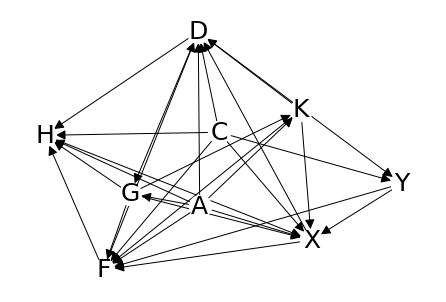

In [5]:

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pc_alg2 import *

# Graph adapted from Peters, Janzing, Scholkopf 2017
N = 500
C = np.random.randn(N, 1)  # exogenous cause of X
A = 0.8 * np.random.randn(N, 1)  # backdoor adjustment variable (also cause of X)
K = A + 0.1 * np.random.randn(N, 1)  # backdoor adjustment variable (cause of A and Y)
X = C - 2 * A + 0.2 * np.random.randn(N, 1)  # treatment variable
F = 3 * X + 0.8 * np.random.randn(N, 1)  # descendent of treatment variable
D = -2 * X + 0.5 * np.random.randn(N, 1)  # mediator between x and y
G = D + 0.5 * np.random.randn(N, 1)  # descendent of mediator
Y = 2 * K - D + 0.2 * np.random.randn(N, 1)  # outcome variable
H = 0.5 * Y + 0.1 * np.random.randn(N, 1)  # effect of Y

cols = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']
predictors = np.concatenate((C, A, K, X, F, D, G, H), 1)
outcome = Y[:, 0]
df = pd.DataFrame(predictors)
df.columns = cols
df['Y'] = outcome  # <---- dataframe
cols.append('Y')

alpha = 0.01  # false positive rate
knn = 500  # number of nearest neighbours for MI based tests (in general recommend knn /approx (N/10))

# using the modified PC alg originally from pgmpy which takes the additional MI based ci tests
# note that mi based tests will take quite some time to run!
''' ci_test = {'pearsonr', 'gcit', 'chi_square', 'mixed_mi', 'cont_mi', 'independence_match'}
'''

# gcit uses https://github.com/alexisbellot/GCIT/blob/master/Tutorial.ipynb
c = PC_adapted(df)
model = c.estimate(ci_test="gcit", return_type="cpdag", significance_level=alpha, knn=knn)
nx.draw(model, with_labels=True, node_color='white', edge_color='k',
        node_size=500, font_size=25, arrowsize=20, )

In [7]:
model.edges

OutEdgeView([('A', 'K'), ('A', 'X'), ('A', 'F'), ('A', 'G'), ('A', 'H'), ('A', 'D'), ('K', 'X'), ('K', 'F'), ('K', 'D'), ('F', 'D'), ('F', 'H'), ('D', 'Y'), ('D', 'G'), ('D', 'H'), ('C', 'F'), ('C', 'H'), ('C', 'Y'), ('C', 'D'), ('C', 'X'), ('Y', 'X'), ('Y', 'F'), ('H', 'X'), ('X', 'D'), ('X', 'F'), ('G', 'F'), ('G', 'X'), ('G', 'K'), ('G', 'H')])

True C A ()
True C K ()
False C X ()
False C F ()
False C D ()
False C G ()
False C H ()
False C Y ()
False A K ()
False A X ()
False A F ()
False A D ()
False A G ()
False A H ()
False A Y ()
False K X ()
False K F ()
False K D ()
False K G ()
False K H ()
False K Y ()
False X F ()
False X D ()
False X G ()
False X H ()
False X Y ()
False F D ()
False F G ()
False F H ()
False F Y ()
False D G ()
False D H ()
False D Y ()
False G H ()
False G Y ()
False H Y ()
True C X ('D',)
False C F ('G',)
False C D ('H',)
False C G ('H',)
False C H ('G',)
False C Y ('G',)
False A K ('D',)
False A X ('D',)
True A F ('D',)
False A D ('H',)
True A G ('D',)
False A H ('K',)
False A Y ('K',)
False K X ('D',)
True K F ('D',)
True K D ('A',)
True K G ('A',)
True K H ('A',)
True K Y ('A',)
False X F ('D',)
False X D ('A',)
True X G ('D',)
False X H ('D',)
False X Y ('D',)
False F D ('C',)
True F G ('D',)
True F H ('X',)
True F Y ('D',)
False D G ('C',)
False D H ('C',)
False D Y ('C',)
True G H ('D',)
Tru

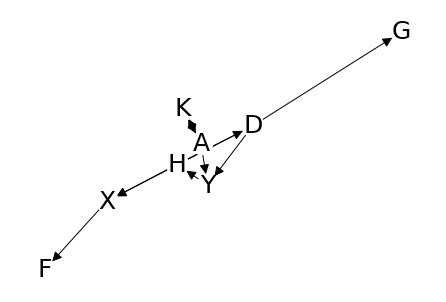

In [8]:
# gcit uses https://github.com/alexisbellot/GCIT/blob/master/Tutorial.ipynb
c = PC_adapted(df)
model2 = c.estimate(ci_test="pearsonr", return_type="cpdag", significance_level=alpha, knn=knn)
nx.draw(model2, with_labels=True, node_color='white', edge_color='k',
        node_size=500, font_size=25, arrowsize=20, )

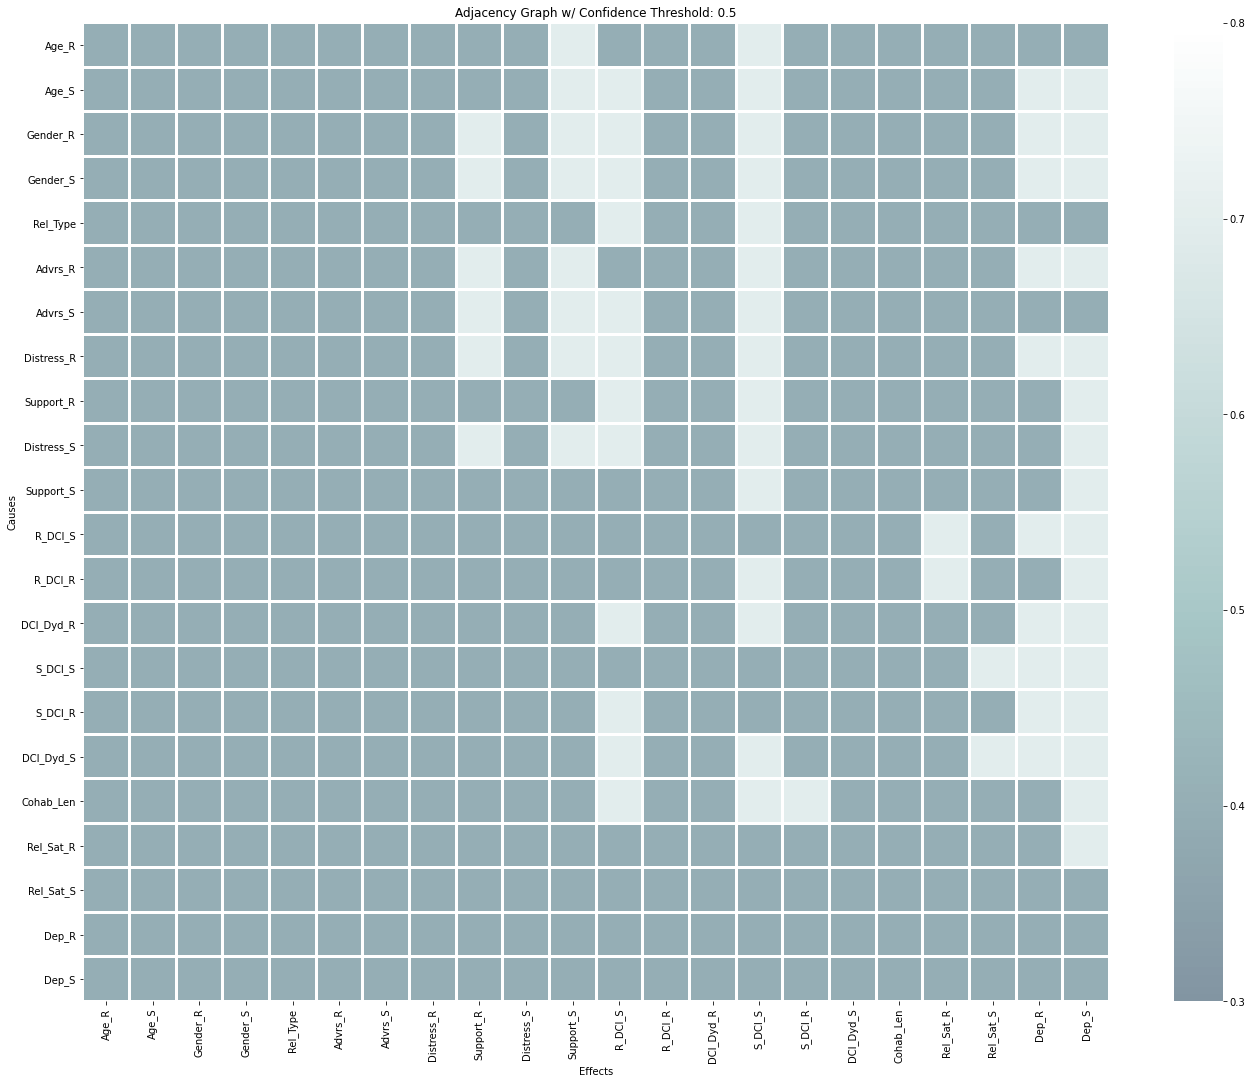

In [41]:
cmap = plt.get_cmap('bone')
cm = nx.adjacency_matrix(G_thresh).todense()
df_cm = pd.DataFrame(cm, index=cols,
          columns=cols)

plt.figure(figsize = (23,18))
sns.heatmap(df_cm.clip(lower=0.4, upper=0.7), linewidths=2, vmin=0.3, vmax=0.8, cmap=cmap, center=0.2)
plt.xlabel('Effects')
plt.ylabel('Causes')
name = 'Adjacency Graph w/ Confidence Threshold: {}'.format(threshold)
plt.title(name)
plt.show()  

In [41]:
rd.edges

OutEdgeView([('Age_R', 'Support_S'), ('Age_R', 'S_DCI_S'), ('Age_S', 'Support_S'), ('Age_S', 'R_DCI_S'), ('Age_S', 'S_DCI_S'), ('Age_S', 'Dep_R'), ('Age_S', 'Dep_S'), ('Gender_R', 'Support_R'), ('Gender_R', 'Support_S'), ('Gender_R', 'R_DCI_S'), ('Gender_R', 'S_DCI_S'), ('Gender_R', 'Dep_R'), ('Gender_R', 'Dep_S'), ('Gender_S', 'Support_R'), ('Gender_S', 'Support_S'), ('Gender_S', 'R_DCI_S'), ('Gender_S', 'S_DCI_S'), ('Gender_S', 'Dep_R'), ('Gender_S', 'Dep_S'), ('Rel_Type', 'R_DCI_S'), ('Rel_Type', 'S_DCI_S'), ('Advrs_R', 'Support_R'), ('Advrs_R', 'Support_S'), ('Advrs_R', 'S_DCI_S'), ('Advrs_R', 'Dep_R'), ('Advrs_R', 'Dep_S'), ('Advrs_S', 'Support_R'), ('Advrs_S', 'Support_S'), ('Advrs_S', 'R_DCI_S'), ('Advrs_S', 'S_DCI_S'), ('Distress_R', 'Support_R'), ('Distress_R', 'Support_S'), ('Distress_R', 'R_DCI_S'), ('Distress_R', 'S_DCI_S'), ('Distress_R', 'Dep_R'), ('Distress_R', 'Dep_S'), ('Support_R', 'R_DCI_S'), ('Support_R', 'S_DCI_S'), ('Support_R', 'Dep_S'), ('Distress_S', 'Support_R

In [13]:
mapping = {}
for node in rd.nodes():
    mapping[node] = ''.join(node.split('_')).lower()

rd = nx.relabel_nodes(rd, mapping)



In [14]:
mapping

{'Age_R': 'ager',
 'Age_S': 'ages',
 'Gender_R': 'genderr',
 'Gender_S': 'genders',
 'Rel_Type': 'reltype',
 'Advrs_R': 'advrsr',
 'Advrs_S': 'advrss',
 'Distress_R': 'distressr',
 'Support_R': 'supportr',
 'Distress_S': 'distresss',
 'Support_S': 'supports',
 'R_DCI_S': 'rdcis',
 'R_DCI_R': 'rdcir',
 'DCI_Dyd_R': 'dcidydr',
 'S_DCI_S': 'sdcis',
 'S_DCI_R': 'sdcir',
 'DCI_Dyd_S': 'dcidyds',
 'Cohab_Len': 'cohablen',
 'Rel_Sat_R': 'relsatr',
 'Dep_R': 'depr',
 'Dep_S': 'deps'}

In [15]:
new_cause = mapping[cause]
new_effect = mapping[outcome]

'Dep_R'

In [24]:
edges = list(rd.edges)

edge_string = []
for edge in edges:
    from_ = edge[0]
    to_ = edge[1]
    edge_string.append(str(from_) + '->' + str(to_))
    
gg = causaleffect.createGraph(edge_string)

In [27]:
P = causaleffect.ID({new_effect}, {new_cause}, gg)

ValueError: no such vertex: 'depr'

In [50]:
G3c = createGraph(["T->Y", "T<->Y"])

['T', 'Y']
T Y
['T', 'Y']
T Y


In [51]:
P  = causaleffect.ID({'Y'}, {'T'}, G3c, verbose=False)

HedgeFound: Causal effect not identifiable. A hedge has been found:

C-Forest 1:
Vertices: T, Y
Edges: T->Y, T<->Y

C-Forest 2:
Vertices: Y
Edges: 

In [8]:
precs

{'Advrs_R',
 'Advrs_S',
 'Age_R',
 'Age_S',
 'Cohab_Len',
 'DCI_Dyd_R',
 'DCI_Dyd_S',
 'Distress_S',
 'Gender_R',
 'Gender_S',
 'R_DCI_R',
 'Rel_Type',
 'S_DCI_R'}